# Supervised Adversarial Networks for Depth Maps Generation
Following the 2017 paper by Pan et al: *Supervised Adversarial Networks for Image Saliency Detection*

In [2]:
!pip uninstall -y scipy

!pip install scipy==1.1.0


'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import tensorflow as tf
import numpy as np
from scipy.misc import imresize
from matplotlib import pyplot as plt

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

In [2]:
#Make3D data
#from Make3D import train_pairs, test_pairs

# NYU data
from NYU import nyu_data
train_pairs, test_pairs = nyu_data()

## Preprocessing

In [3]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7545744925600550275
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5088018432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 804802069260290661
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
tf.device('/GPU:0')

In [5]:
import cv2
def imresize(inputs,shape):
    return cv2.resize(src=inputs, dsize=shape, interpolation=cv2.INTER_CUBIC)

train input/target shapes (512, 512) (512, 512)
train input min/max/ptp -48.71324328627437 305.1322032540254 353.84544654029975
train target min/max/ptp 0.18807173 10.550225 10.362154


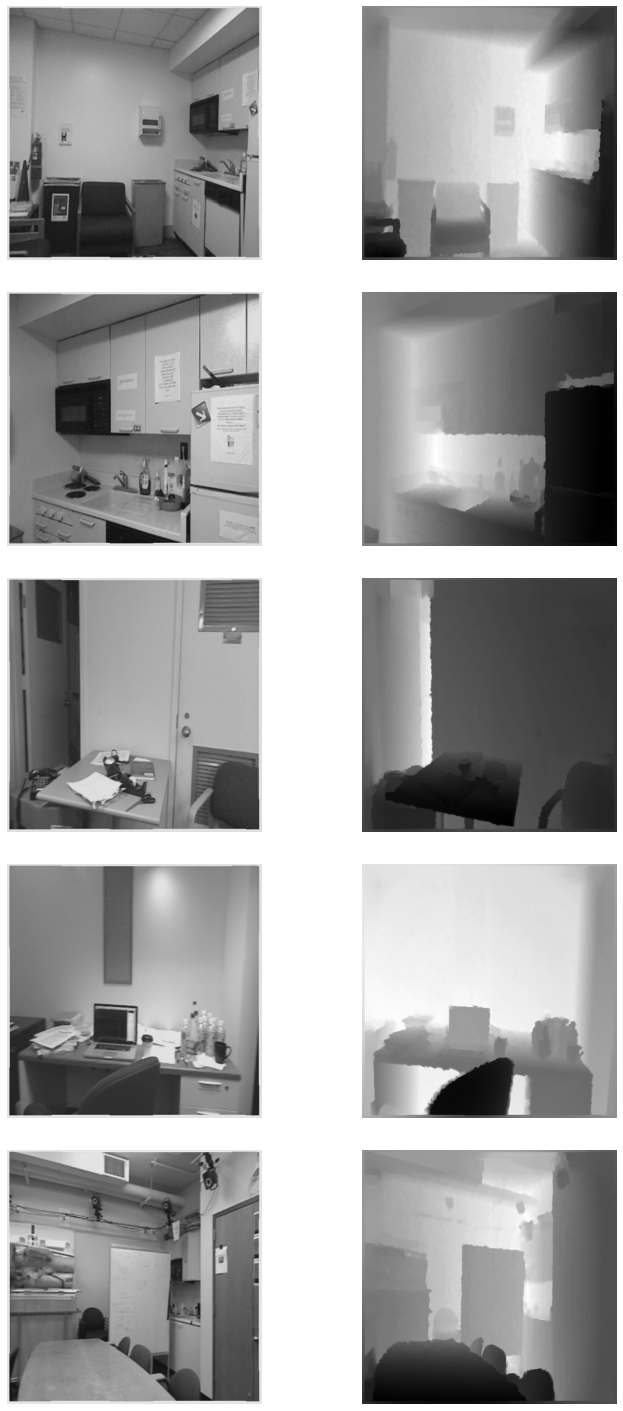

In [6]:
shape = (512, 512)

train_data, train_targets = zip(*train_pairs)
test_data, test_targets = zip(*test_pairs)


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


def resize(img):
    return imresize(img, shape)


train_data = [resize(rgb2gray(img)) for img in train_data]
train_targets = [resize(img) for img in train_targets]
test_data = [resize(rgb2gray(img)) for img in test_data]
test_targets = [resize(img) for img in test_targets]

train_x, train_t = np.asarray(train_data), np.asarray(train_targets)
test_x, test_t = np.asarray(test_data), np.asarray(test_targets)

print('train input/target shapes', train_data[0].shape, train_targets[0].shape)
print('train input min/max/ptp', np.min(train_data),
      np.max(train_data), np.ptp(train_data))
print('train target min/max/ptp', np.min(train_targets),
      np.max(train_targets), np.ptp(train_targets))

tuples = zip(train_x[:10], train_t[:10])
fig, axis = plt.subplots(5, 2, figsize=(10, 20))
plt.tight_layout(), plt.gray()
for (rgb, d), (ax1, ax2) in zip(tuples, axis):
    ax1.axis('off'), ax2.axis('off')
    ax1.imshow(rgb)
    ax2.imshow(imresize(d, rgb.shape))
# plt.show()

In [7]:
from tensorflow.contrib.framework import get_variables


def lrelu(x, alpha=0.2):
    """Leaky rectifier."""
    return tf.maximum(alpha * x, x)


def conv2d(inputs, num_outputs, kernel_size=(4, 4), strides=2,
           padding='SAME', activation=lrelu, norm=False, training=False):
    """Wrapper for tf.layers.conv2d with default parameters."""
    net = tf.layers.conv2d(inputs, num_outputs, kernel_size, strides,
                           padding=padding)
    if norm:
        net = tf.layers.batch_normalization(net, training=training)
    return activation(net)


def conv2d_transpose(inputs, num_outputs, kernel_size=(4, 4), strides=2,
                     padding='SAME', activation=tf.nn.relu, norm=False,
                     training=False):
    """Wrapper for tf.layers.conv2d_transpose with default parameters."""
    net = tf.layers.conv2d_transpose(inputs, num_outputs, kernel_size,
                                     strides, padding=padding)
    if norm:
        net = tf.layers.batch_normalization(net, training=training)
    return activation(net)

In [8]:
def make_discriminator(images, is_training):
    """Discriminator.

    Args:
        images (tf.Tensor[tf.float32]): Input images, either from generator
            or real inputs. Shape (BATCH, 256, 256, (input_c + output_c))
        is_training (tf.Tensor[tf.bool]): True when in training, False 
            when in testing step.

    Returns:
        (tf.Tensor): Sigmoid network output, single scalar in [0, 1].
        (tf.Tensor): Linear network output, single scalar.
        (List[tf.Operation]): Batch normalization update operations.
    """
    with tf.variable_scope('discriminator') as scope:
        net = images
        net = conv2d(net, 64)
        net = conv2d(net, 128, norm=True, training=is_training)
        net = conv2d(net, 256, norm=True, training=is_training)
        net = conv2d(net, 512, norm=True, training=is_training)
        net = conv2d(net, 1, (1, 1))
        logits = tf.layers.dense(net, 1, tf.identity)
        out = tf.nn.sigmoid(logits)
    theta = get_variables(scope)
    ops = get_variables(scope, collection=tf.GraphKeys.UPDATE_OPS)
    return out, logits, theta, ops

In [9]:
def make_generator(images, is_training):
    """Generator.

    Args:
        images (tf.Tensor[tf.float32]): Input images, either from generator
            or real inputs. Shape (BATCH, 256, 256, (input_c + output_c))
        is_training (tf.Tensor[tf.bool]): True when in training, False 
            when in testing step.

    Returns:
        (tf.Tensor): Tanh network output, single channel shaped as input.
        (List[tf.Operation]): Batch normalization update operations.

    TODO: Implement skipping between encoder and decoder.
    """

    with tf.variable_scope('generator') as scope:
        with tf.variable_scope('encoder'): # 256x256
            net = images
            enc0 = conv2d(net, 64)  # 128x128
            enc1 = conv2d(enc0, 128, norm=True, training=is_training)  # 64x64
            enc2 = conv2d(enc1, 256, norm=True, training=is_training)  # 32x32
            enc3 = conv2d(enc2, 512, norm=True, training=is_training)  # 16x16
            enc4 = conv2d(enc3, 512, norm=True, training=is_training)  # 8x8
            enc5 = conv2d(enc4, 512, norm=True, training=is_training)  # 4x4
            enc6 = conv2d(enc5, 512, norm=True, training=is_training)  # 2x2x512
            enc7 = conv2d(enc6, 512, norm=True, training=is_training)  # 1x1x512
            enc8 = conv2d(enc7, 1024, norm=True, training=is_training)  # 1x1x512
        with tf.variable_scope('decoder'):
            dec = conv2d_transpose(enc8, 1024, norm=True, training=is_training)  # 2x2
            dec = tf.layers.dropout(dec, .5)  # 512
            dec = conv2d_transpose(enc7, 512, norm=True, training=is_training)  # 2x2
            dec = tf.layers.dropout(dec, .5)  # 512
            dec = tf.concat([dec, enc6], axis=-1)  # 1024
            dec = conv2d_transpose(dec, 512, norm=True, training=is_training)  # 4x4
            dec = tf.layers.dropout(dec, .5)
            dec = tf.concat([dec, enc5], axis=-1)  # 1024
            dec = conv2d_transpose(dec, 512, norm=True, training=is_training)  # 8x8
            dec = tf.layers.dropout(dec, .5)
            dec = tf.concat([dec, enc4], axis=-1)  # 1024
            dec = conv2d_transpose(dec, 512, norm=True, training=is_training)  # 16x16
            dec = tf.concat([dec, enc3], axis=-1)  # 1024
#             dec = conv2d_transpose(dec, 512, norm=True, training=is_training)
            dec = conv2d_transpose(dec, 256, norm=True, training=is_training)  # 32x32
            dec = tf.concat([dec, enc2], axis=-1)  # 512
            dec = conv2d_transpose(dec, 128, norm=True, training=is_training)  # 64x64
            dec = tf.concat([dec, enc1], axis=-1)  # 256
            dec = conv2d_transpose(dec, 64, norm=True, training=is_training)  # 128x128
            dec = tf.concat([dec, enc0], axis=-1)  # 128
            out = conv2d_transpose(dec, 1, activation=tf.nn.tanh)  # 256x256
        theta = get_variables(scope)
        ops = get_variables(scope, collection=tf.GraphKeys.UPDATE_OPS)
        return out, theta, ops

In [10]:

tf.device('/GPU:0')

In [11]:

tf.reset_default_graph()

is_training = tf.placeholder_with_default(False, None)
images = tf.placeholder(tf.uint8, (None, 512, 512), name='inputs')
depthmaps = tf.placeholder(tf.uint8, (None, 512, 512), name='targets')


def scale(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.


images_ = tf.reshape(scale(images), (-1, 512, 512, 1))
depthmaps_ = tf.reshape(scale(depthmaps), (-1, 512, 512, 1))

# Create generator (and sampler?)
# remake_generator = tf.make_template('generator', make_generator)
generator, g_theta, g_ops = make_generator(images_, is_training)
# sampler = remake_generator(images_, is_training)


def soft_labels_like(like, real=False):
    if real:
        return tf.random_uniform(tf.shape(like), 0.7, 1.2, tf.float32)
    else:
        return tf.random_uniform(tf.shape(like), 0., 0.3, tf.float32)


# Create the two discriminator graphs.
real = tf.concat([images_, depthmaps_], axis=-1)
fake = tf.concat([images_, generator], axis=-1)
remake_discriminator = tf.make_template('discriminator', make_discriminator)
d_real, d_logits_real, d_theta, d_ops = remake_discriminator(real, is_training)
d_fake, d_logits_fake, _, _ = remake_discriminator(fake, is_training)

# Create discriminator losses.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_real, labels=tf.ones_like(d_real)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake, labels=tf.zeros_like(d_fake)))
d_loss = d_loss_real + d_loss_fake

LAMBDA = 100

# Create generator loss.
ganloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_fake)))
l1loss = tf.reduce_mean(tf.abs(depthmaps_ - generator))
g_loss = ganloss + LAMBDA * l1loss

with tf.control_dependencies(g_ops):
    g_op = tf.train.AdamOptimizer(1e-4, beta1=0.5).minimize(g_loss, var_list=g_theta)

with tf.control_dependencies(d_ops):
    d_op = tf.train.AdamOptimizer(1e-4, beta1=0.5).minimize(g_loss, var_list=g_theta)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training

In [12]:
def batches(x, y, batchsize=32):
    permute = np.random.permutation(len(train_t))
    for i in range(0, len(train_t)-1, batchsize):
        indices = permute[i*batchsize:i*batchsize+batchsize]
        yield x[indices], y[indices]    

In [13]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [14]:
EPOCHS = 120
RESTORE = 'pix2pix--54'
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#saver = tf.train.Saver()

#if RESTORE is not None:
#    sess.run(tf.global_variables_initializer())
#else:
#    saver.restore(sess, RESTORE)


def moving_average(current, previous=None, alpha=0.01):
    try:
        return alpha * current + (1 - alpha) * previous
    except:
        return loss


mavg_d_loss = None
mavg_g_loss = None
dis = []
gen = []
batch = 0
for epoch in range(1, EPOCHS + 1):
    for batch_x, batch_t in batches(train_x, train_t, 1):
        batch += 1
        if batch % 2 == 0:
            loss, _ = sess.run([d_loss, d_op],
                               {images: batch_x, depthmaps: batch_t,
                                is_training: True})
            mavg_d_loss = moving_average(loss, mavg_d_loss)
    
        else:
            loss, _ = sess.run([g_loss, g_op],
                               {images: batch_x, depthmaps: batch_t,
                                is_training: True})
            mavg_g_loss = moving_average(loss, mavg_g_loss)
    gen.append(mavg_g_loss)
    dis.append(mavg_d_loss)
    #saver.save(sess, 'pix2pix-', global_step=epoch)
    print('Loss after epoch {}: Dis. {:.4f}, Gen. {:.4f}'
          .format(epoch, mavg_d_loss, mavg_g_loss))

Loss after epoch 1: Dis. 1.3869, Gen. 1.7993
Loss after epoch 2: Dis. 1.3869, Gen. 1.4236
Loss after epoch 3: Dis. 1.3869, Gen. 1.3940
Loss after epoch 4: Dis. 1.3869, Gen. 1.3793
Loss after epoch 5: Dis. 1.3868, Gen. 1.4002
Loss after epoch 6: Dis. 1.3868, Gen. 1.3655
Loss after epoch 7: Dis. 1.3868, Gen. 1.3661
Loss after epoch 8: Dis. 1.3868, Gen. 1.3000
Loss after epoch 9: Dis. 1.3868, Gen. 1.2985
Loss after epoch 10: Dis. 1.3868, Gen. 1.2761
Loss after epoch 11: Dis. 1.3868, Gen. 1.2286
Loss after epoch 12: Dis. 1.3868, Gen. 1.2329
Loss after epoch 13: Dis. 1.3868, Gen. 1.2065
Loss after epoch 14: Dis. 1.3868, Gen. 1.1619
Loss after epoch 15: Dis. 1.3868, Gen. 1.1757
Loss after epoch 16: Dis. 1.3868, Gen. 1.1333
Loss after epoch 17: Dis. 1.3868, Gen. 1.1346
Loss after epoch 18: Dis. 1.3868, Gen. 1.0973
Loss after epoch 19: Dis. 1.3868, Gen. 1.1063
Loss after epoch 20: Dis. 1.3868, Gen. 1.0745
Loss after epoch 21: Dis. 1.3868, Gen. 1.0561
Loss after epoch 22: Dis. 1.3868, Gen. 1.04

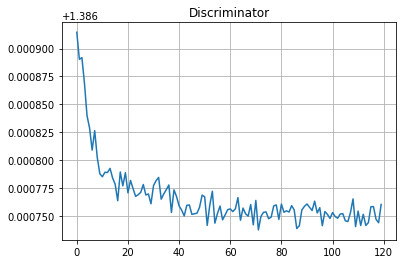

In [15]:
plt.plot(dis)
plt.grid(True)
plt.title('Discriminator')
plt.show()

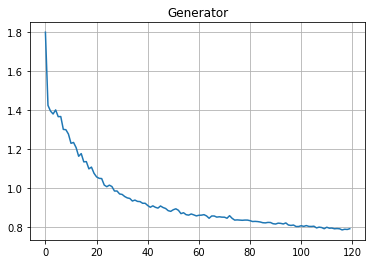

In [16]:

plt.plot(gen)
plt.grid(True)
plt.title('Generator')
plt.show()

In [17]:
test_p = sess.run(generator, {images: test_x[:10]})
test_p = np.clip(((test_p + 1) / 2), 0, 255)
print(np.unique(test_p))



# plt.figure()
# plt.hist(np.reshape(test_p, -1), normed=True, log=False)
# plt.show()

[1.0281801e-05 1.0639429e-05 1.0877848e-05 ... 1.8203974e-02 1.8340409e-02
 1.9635499e-02]


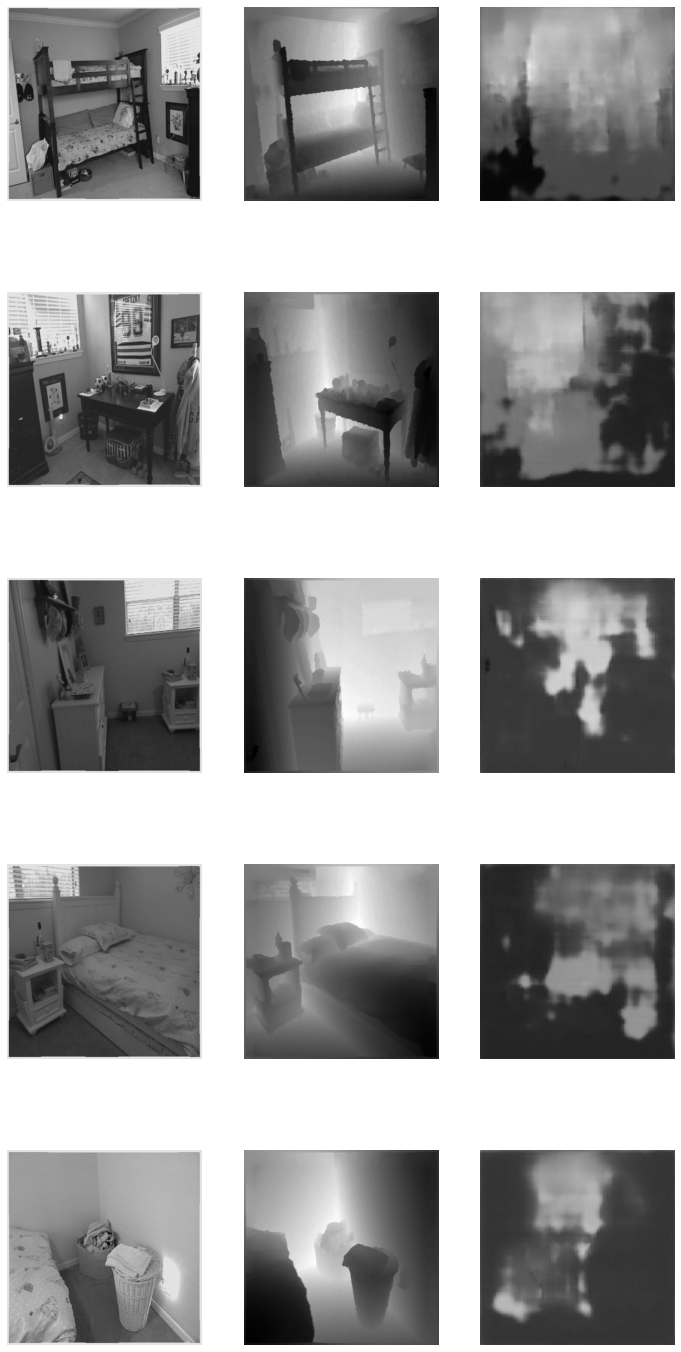

In [18]:
triples = zip(test_x[:10], test_t[:10], test_p[:10])
_, axis = plt.subplots(5, 3, figsize=(10, 20))
plt.tight_layout(), plt.gray()
for (rgb, d, p), (ax1, ax2, ax3) in zip(triples, axis):
    ax1.axis('off'), ax2.axis('off'), ax3.axis('off')
    ax1.imshow(rgb)
    ax2.imshow(d)
    ax3.imshow(np.squeeze(p))
plt.show()

In [19]:
from PIL import Image
import numpy as np
import cv2

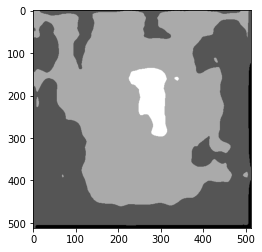

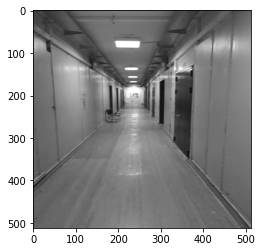

In [20]:
im1 = Image.open('a2.jpg').convert('L')
im2arr1 = np.array(im1)
im2arr1 = np.reshape(im2arr1,(1,512,512))



test_p = sess.run(generator, {images: im2arr1})
test_p = np.clip(((test_p + 1) / 2), 0, 255)
test_p = np.reshape(test_p, (512,512))

#test_p = abs(test_p)

#plt.plot(test_p)
'''for i in range(512):
  for j in range(512):
    if test_p[i][j]<0.2 or 1.75<test_p[i][j]:
      test_p[i][j]+=0.5


print(test_p.mean())
test_p = test_p/test_p.max()'''



#test_p = cv2.normalize(test_p, test_p, 0, 30, norm_type=cv2.NORM_MINMAX)
test_p = cv2.GaussianBlur(test_p,(0,0),3)


def negative(source):
    
    
    for x in range(source.size[0]):
        for y in range(source.size[1]):
            r = source.getpixel((x, y))
            source.putpixel((x, y), (255 - r))
    return source.convert('L')

#test_p = negative(test_p)

test_p = Image.fromarray(np.squeeze(test_p)*255).convert('L')

fig, ax = plt.subplots()
ax.imshow(test_p)


fig, ax = plt.subplots()
ax.imshow(im1)

plt.show()


test_p.save('test.jpg')

In [21]:
saver = tf.train.Saver()
saver.save(sess, 'model2')

'model2'